# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, … Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import json
import numpy as np
import seaborn as sns
import re
import vincent # pip install vincent
sns.set_context("notebook")

folium.__version__ == '0.5.0'

True

## Question 1
-- --

Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

## Solution 1
-- --



We choose this dataset http://ec.europa.eu/eurostat/web/products-datasets/-/tepsr_wc170, mainly because it included switzerland and was pretty recent (2016). It represents the unemployment rate per age category, but one of the categories span age 15 to 74, which we took for the total population concerned. 

The data was saved in a .tsv , which is almost like a .csv except the columns had two differents separators.
Using panda, we separated the columns and took only the rows concerning the age from 15 to 74 slice, removed the totals for the EU (European Union) and EA (Euro Area), and only looked at the 2016 values.

We also needed to rename EL to GR (Greece) and UK to GB (Great Britain).

In [2]:
eurostat = pd.read_csv("tepsr_wc170.tsv", usecols=['age', r'geo\time', '2016'], sep=r'\t|,', engine='python')

eurostat.columns = ['age', 'country', '2016']
eurostat['2016'] = eurostat['2016'].replace(r'.b', '', regex=True).apply(pd.to_numeric)

eurostat = eurostat.loc[eurostat.age == 'Y15-74']
eurostat = eurostat.loc[~eurostat.country.str.contains('.*EU|EA.*')]

eurostat.set_index('country', inplace=True)
eurostat = eurostat[['2016']]
#We rename EL to GR, and UK to GB, as we want the identification code to be the same with the one in the topojson
#It seems that in the topojson data, they have mixed the UK with the GB, even if those are two different zones.
eurostat = eurostat.rename({'EL':'GR', 'UK':'GB'})

unemployment_per_country = eurostat['2016']
eurostat.head()

,2016
country,
AT,6.0
BE,7.8
BG,7.6
CH,5.0
CY,13.0


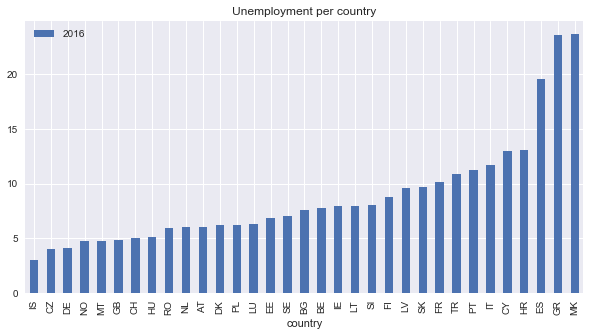

In [3]:
sorted_eur = eurostat.sort_values('2016')
sorted_eur.plot.bar(title='Unemployment per country', figsize=(10, 5))
plt.show()

If we check the countries that are available in the topology data, we see that there are way more countries than available data about them. In fact, the countries with not data available are :

- Azerbaijan
- Albania
- Armenia
- Bosnia and Herzegovina
- Georgia
- Israel
- Belarus
- Liechtenstein
- Faroe Islands
- Andorra
- Monaco
- Montenegro
- Republic of Moldova
- Ukraine
- San Marino
- Serbia
- Holy See (Vatican City)
- Russia

Some countries like Israel are not in Europe, so it's not a problem, but for some countries like Ukraine, then no data will be available in the map. We will plot them as gray on the map.

In [4]:
countries_geo_path = r'topojson/europe.topojson.json'
geo_json_data = json.load(open(countries_geo_path))

countries_geo_available = []
for c in geo_json_data.get('objects').get('europe').get('geometries'):
    countries_geo_available += [c.get('id')]
    
' | '.join(countries_geo_available)

'AZ | AL | AM | BA | BG | CY | DK | IE | EE | AT | CZ | FI | FR | GE | DE | GR | HR | HU | IS | IL | IT | LV | BY | LT | SK | LI | MK | MT | BE | FO | AD | LU | MC | ME | NL | NO | PL | PT | RO | MD | SI | ES | SE | CH | TR | GB | UA | SM | RS | VA | RU'

In [5]:
countries_geo_keep = []
countries_with_data = eurostat.index
countries_geo_na = []

for c in geo_json_data.get('objects').get('europe').get('geometries'):
    if(c.get('id') in countries_with_data):
        countries_geo_keep += [c]
    else:
        countries_geo_na += [c]
        
new_geo_json_data = json.load(open(countries_geo_path))
new_geo_json_data.get('objects').get('europe')['geometries'] = countries_geo_keep

na_geo_json_data = json.load(open(countries_geo_path))
na_geo_json_data.get('objects').get('europe')['geometries'] = countries_geo_na

print("Countries with no data : ")
[print(c['id'], end=' | ') for c in countries_geo_na]
pass

Countries with no data : 
AZ | AL | AM | BA | GE | IL | BY | LI | FO | AD | MC | ME | MD | UA | SM | RS | VA | RU | 

In [6]:
europe_coord = [53.5775, 23.106111]
europe_map = folium.Map(location=europe_coord, tiles='cartodbpositron', zoom_start=3)

As we can have at most 5 different colors for the map, we have maximized the number of countries per category by separating them using quantiles.

In [7]:
unemployment_data = unemployment_per_country

_, bins = pd.qcut(unemployment_data, 5, retbins=True)
bins[0] -= 0.1
bins[-1] += 0.1

print('Scale used:', bins)


europe_map.choropleth(geo_data=new_geo_json_data, data=unemployment_data,
             topojson='objects.europe',
             highlight=True,
             key_on='id',
             threshold_scale = list(bins),
             fill_color='GnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment rates for european countries (% of active population)')

folium.TopoJson(
    na_geo_json_data,
    'objects.europe',
    overlay=True,
    name='topojson',
    style_function=lambda feature: {
        'fillColor': '#101010',
        'color' : 'black',
        'weight' : 0,
        'dashArray' : '5, 5'
        }
).add_to(europe_map)


folium.LayerControl().add_to(europe_map)


europe_map

Scale used: [  2.9    5.04   6.28   7.92  11.08  23.8 ]


In this map, and in the previous plot, we can see that Switzerland is one of the best countries in Europe if we compare the unemployment rate. It's the 7th country in Europe.

## Question 2
-- --

Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

  The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

  -- --

We went to amstat, and we navigated to this section : https://www.amstat.ch/MicroStrategy/servlet/mstrWeb.
We then chose "Taux de chômage", unselected "Coefficients de variation", checked "Canton" and clicked on "Exécuter le rapport". Then, we could have the data in xlsx format.

In [53]:
amstat = pd.read_excel(
    '2_1 Taux de chomage.xlsx', 
    skiprows=[0,1,3,82], 
    usecols=['Canton', 'Unnamed: 2', 'Septembre 2017', 'Septembre 2017.1', 'Septembre 2017.2', 'Septembre 2017.3'])

amstat_all = pd.read_excel(
    '2_1 Taux de chomage_all.xlsx', 
    skiprows=[0,1,3,30], 
    usecols=['Canton', 'Septembre 2017','Septembre 2017.2', 'Septembre 2017.3', 'Septembre 2017.4'])

In [54]:
amstat.columns = ['Canton', 'Age category', 'Percentage of unemployed', 'Number of unemployed',' Job seekers', 'Job seekers not unemployed']
amstat_all.columns = ['Canton', 'Percentage of unemployed', 'Number of unemployed', 'Number of job seekers', 'Number of job seekers with job']

In this part, we begin by defining the Canton name - code equivalents. This will be useful later, when we need to make the topojson and amstat data map together easily.

In [55]:
canton_to_id = {
    'Zurich': 'ZH',
    'Berne' : 'BE',
    'Lucerne' : 'LU',
    'Uri' : 'UR',
    'Schwyz' : 'SZ',
    'Obwald' : 'OW',
    'Nidwald' : 'NW',
    'Glaris' :'GL',
    'Zoug' : 'ZG',
    'Fribourg' : 'FR',
    'Soleure' : 'SO',
    'Bâle-Ville' : 'BL',
    'Bâle-Campagne' : 'BS',
    'Schaffhouse' : 'SH',
    'Appenzell Rhodes-Extérieures' : 'AR',
    'Appenzell Rhodes-Intérieures' : 'AI',
    'St-Gall' : 'SG',
    'Grisons' : 'GR',
    'Argovie' : 'AG',
    'Thurgovie' : 'TG',
    'Tessin' : 'TI',
    'Vaud' : 'VD',
    'Valais'  : 'VS',
    'Neuchâtel' : 'NE',
    'Genève' : 'GE',
    'Jura' : 'JU',
    'Appenzell Ausser-Rhoden' : 'AR',
    'Appenzell Inner-Rhoden' : 'AI',
    'Bâle Campagne' : 'BS',
    'Saint-Gall' : 'SG'
}

canton_to_coord = {
    'ZH':'47.37689 N, 8.54169 E',
    'BE':'46.94797 N, 7.44745 E',
    'LU':'47.05017 N, 8.30931 E',
    'UR':'46.77386 N, 8.60252 E',
    'SZ':'47.02071 N, 8.65299 E',
    'OW': '46.87786 N, 8.25125 E',
    'NW':'46.9267 N, 8.385 E',
    'GL' : '47.04043 N, 9.06721 E',
    'ZG':'47.16617 N, 8.51549 E',
    'FR' : '46.80648 N, 7.16197 E',
    'SO': '47.20883 N, 7.53229 E',
    'BL' : '47.56193 N, 7.59277 E',
    'SH' : '47.69589 N, 8.63805 E',
    'GR' : '46.65699 N, 9.57803 E',
    'AG' : '47.38767 N, 8.25543 E',
    'TG' : '47.60379 N, 9.05574 E',
    'TI' : '46.33173 N, 8.80045 E',
    'VD' : '46.56131 N, 6.53677 E',
    'VS' :'46.19046 N, 7.54492 E',
    'NE': '46.98999 N, 6.92927 E',
    'GE':'46.20439 N, 6.14316 E',
    'JU': '47.34445 N, 7.14306 E',
    'AR': '47.36648 N, 9.30009 E',
    'AI':'47.31619 N, 9.43166 E',
    'BS' : '47.44181 N, 7.7644 E',
    'SG':'47.42448 N, 9.37672 E'
}

We map the name of the canton to their to letters id to be able to match them with the cantons drawn on the map. 

In [57]:
amstat['canton_id'] =  amstat['Canton'].apply(lambda x: canton_to_id[x])
amstat_all['canton_id'] =  amstat_all['Canton'].apply(lambda x: canton_to_id[x])
amstat_all['Number of job seekers minus those already with a job'] = amstat_all['Number of job seekers'] - amstat_all['Number of job seekers with job']
amstat_all = amstat_all.set_index('canton_id')

In [62]:
amstat_all

,Canton,Percentage of unemployed,Number of unemployed,Number of job seekers,Number of job seekers with job,Number of job seekers minus those already with a job
canton_id,,,,,,
ZH,Zurich,3.3,27225,34156,3984,30172
BE,Berne,2.4,13658,18385,2142,16243
LU,Lucerne,1.7,3885,6756,1134,5622
UR,Uri,0.6,112,257,67,190
SZ,Schwyz,1.7,1455,2229,264,1965
OW,Obwald,0.7,153,319,26,293
NW,Nidwald,1.0,248,436,28,408
GL,Glaris,1.8,416,713,154,559
ZG,Zoug,2.3,1543,2615,391,2224


In [58]:
cat_1 = amstat_all['Percentage of unemployed']
cat_2 = amstat_all['Number of unemployed']
cat_3 = amstat_all['Number of job seekers']
cat_4 = amstat_all['Number of job seekers minus those already with a job']
indexed_amstat = amstat.set_index(['canton_id', 'Age category'])

For each canton we created a pin clicking on which will show a graph with the percentage of unemployed or the number of unemployed by age category depending of the map.

In [80]:
m_swiss_perc = folium.Map([46.85,8.3], tiles='cartodbpositron', zoom_start=7.5)

m_swiss_perc.choropleth(geo_data=open(r'topojson/ch-cantons.topojson.json'), topojson='objects.cantons', data=cat_1,
             key_on='id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Rate of unemployment per cantons (% of active population)',
             highlight = True)


m_swiss_nb = folium.Map([46.85,8.3], tiles='cartodbpositron', zoom_start=7.5)

m_swiss_nb.choropleth(geo_data=open(r'topojson/ch-cantons.topojson.json'), topojson='objects.cantons', data=cat_2,
             key_on='id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Number of unemployed per cantons',
             highlight = True)

m_swiss_seeker = folium.Map([46.85,8.3], tiles='cartodbpositron', zoom_start=7.5)

m_swiss_seeker.choropleth(geo_data=open(r'topojson/ch-cantons.topojson.json'), topojson='objects.cantons', data=cat_3,
             key_on='id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Number of job seekers per cantons',
             highlight = True)

m_swiss_seeker2 = folium.Map([46.85,8.3], tiles='cartodbpositron', zoom_start=7.5)

m_swiss_seeker2.choropleth(geo_data=open(r'topojson/ch-cantons.topojson.json'), topojson='objects.cantons', data=cat_4,
             key_on='id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Number of job seekers minus those already with a job',
             highlight = True)

for canton, id_ in canton_to_id.items():
    coord = re.findall('\d+\.\d+', canton_to_coord[id_])
    coord = [float(coord[0]), float(coord[1])]
    
    percentage = indexed_amstat.loc[id_]['Percentage of unemployed']
    percentage.columns = 'Unemployed'
    bar_perc = vincent.Bar(percentage, width=300, height=200)
    bar_perc.scales['x'].padding = 0.2
    bar_perc.legend(title=canton)
    bar_perc.axis_titles(x='Age category', y='Percentage of unemployed')
    
    number = indexed_amstat.loc[id_]['Number of unemployed']
    bar_nb = vincent.Bar(number, width=300, height=200)
    bar_nb.scales['x'].padding = 0.2
    bar_nb.axis_titles(x='Age category', y='Number of unemployed')
    
    folium.RegularPolygonMarker(coord, 
                                popup = folium.Popup(max_width=450).add_child(
        folium.Vega(bar_perc, width=450, height=250)), 
                                fill_color = '#0000ff',
                                number_of_sides = 8, 
                                radius = 6).add_to(m_swiss_perc)
    
    folium.RegularPolygonMarker(coord, 
                                popup = folium.Popup(max_width=450).add_child(
        folium.Vega(bar_nb, width=450, height=250)), 
                                fill_color = '#0000ff',
                                number_of_sides = 8, 
                                radius = 6).add_to(m_swiss_nb)

We can observe that the trend here seems to be that the cantons in the swiss-french part of the country have a higher rate of unemployment. It seems that the cantons closer to the border with France, Germany and Italy suffer the most. 

In [81]:
m_swiss_perc

For this part, we don't take into consideration the number of job seekers currently with a job. We can see that the numbers we want corresponds simply to unemployed people, so it does not include people who already have a job (even if they are seeking) 
-- --
TO REVIEW :

The rate in percentage is a relative measure and is proportional to the total popultation of each cantons, therefore it looses significance when we are comparing cantons with an important difference in the number of inhabitants, ie Bern and Bale-Campagne seems to have the same level of unemployment but we can see on the next map that the number of unemployed differ by thousands, therefore the percentage looses significance in this example.

Now if we compare using the number of unemployed per cantons, we can see that the trend is completely different. Vaud, Bern and Zurich have the highest number of unemployed, while it is more balanced between the other cantons. Unemployment is really high in Zurich, which could be explained by its important population and the higher wages attracting more people.

In [46]:
m_swiss_nb

In [47]:
m_swiss_seeker

In [65]:
m_swiss_seeker2

In [61]:
m_swiss_perc.save('Swiss_unemployement_by_%.html')
m_swiss_nb.save('Swiss_unemployement_by_nb.html')
m_swiss_seeker.save('Swiss_job_seekers.html')
m_swiss_seeker2.save('Swiss_jobless_job_seekers.html')

## Question 3 - Part 1
-- --

Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

-- --

For this part, we retrieve some data coming from the '2.1 Taux de chômage' category on amstat. We have chosen only the 'Taux de chômage', 'Chômeurs inscrits', 'Canton' and 'Nationality' fields. We only keep the desired columns :

0 for Canton

1 for Nationality

5 for the unemployment rate

We then put the data relative to foreign people in foreign, and data relative to swiss people in swiss.

In [17]:
swiss_foreign = pd.read_excel('chomage_suisse_etrangers.xlsx', skiprows=[1,54],parse_cols=[0, 1,5])
foreign = swiss_foreign[swiss_foreign.iloc[:,1] == 'Etrangers'].iloc[:,[0,2]].set_index('Canton').rename(canton_to_id).squeeze()
swiss = swiss_foreign[swiss_foreign.iloc[:,1] == 'Suisses'].iloc[:,[0,2]].set_index('Canton').rename(canton_to_id).squeeze()
swiss.head()

Canton
ZH    2.5
BE    1.8
LU    1.3
UR    0.4
SZ    1.2
Name: Total, dtype: float64

In [18]:
difference = foreign - swiss

We create three maps centered on Switzerland.

In [19]:
swiss_coord = [46.794, 8.2968]
swiss_map_foreign = folium.Map(location=swiss_coord, tiles='cartodbpositron', zoom_start=8)
swiss_map_swiss = folium.Map(location=swiss_coord, tiles='cartodbpositron', zoom_start=8)
swiss_map_difference = folium.Map(location=swiss_coord, tiles='cartodbpositron', zoom_start=8)

Here, we create the choropleth per map. Initially, we had chosen to use two maps. We have tried the possibility where there is one map with two overlays. However, it's not very well done with Folium, as there is no obvious way of desactivating one layer by default (so that we get one map with both layers activated when it starts). Furthermore, both scales remain on the top of the map, so that it's confusing to understand which scale corresponds to which version.

Finally, we have chosen to use three maps, two for the swiss and foreign cases, and one for the difference in percentage points, between the two rates that we had. Thus, we can show the difference in unemployment rates between the two categories in an easier way. The difference done is foreign - swiss, as it returns only positive values when we do it this way.

In [20]:
swiss_geo_path = r'topojson/ch-cantons.topojson.json'
swiss_json_data = json.load(open(swiss_geo_path))


swiss_map_foreign.choropleth(geo_data=swiss_json_data, data=foreign,
             topojson='objects.cantons',
             highlight=True,
             key_on='id',
             fill_color='GnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment of foreign people (% of canton active foreign population)')

swiss_map_swiss.choropleth(geo_data=swiss_json_data, data=swiss,
             topojson='objects.cantons',
             highlight=True,
             key_on='id',
             fill_color='GnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment of swiss people (% of canton active swiss population)')

swiss_map_difference.choropleth(geo_data=swiss_json_data, data=difference,
             topojson='objects.cantons',
             highlight=True,
             key_on='id',
             fill_color='GnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Difference bet. foreign and swiss people unempl. rate (in percentage points)')


The biggest differences are in the Jura, Bern, Neuchâtel and Argovie cantons, so more in North-Western parts of the country. It's very likely that it's due to the fact that these cantons are closer to the boundaries of the country, especially to France (and Germany). Of course, as all values of the difference array are positive, it means that foreign rates > swiss rates, so for these cantons, it says that the percentage of foreign people unemployed is way bigger than swiss people unemployed.

We could conclude that in these cantons, there are more people that moved in Switzerland from these countries, as the wage is higger, and the quality of life may be better, but because of this, there may be more competition for a given job, or some discrimination against strangers (as a lot moved in).

Note that Vaud and Genève are at the boundary too, however the swiss unemployment rate is also high, so it might compensate the high foreign unemployment rate. Thus, the difference is not very high for these cantons.

In [21]:
swiss_map_difference

In [22]:
swiss_map_foreign

In [23]:
swiss_map_swiss

## Part 2
-- --
Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

-- --
First of all, we don't use the same data as before here. In fact, we use data from the '1.1 Chômeurs et demandeurs d'emploi selon divers critères' section instead of the '2.1 Taux de chômage' one. Why ? In the latter, we only could retrieve one criteria amongst the Nationality and the Age group. As we want both, we chose the former. However, we have to work with an amount of people instead of unemployment rates. 

One could try to create rates from this new dataset and other datasets like the one of the previous part/exercise, however it would involve hard approximations, like assuming independence between the age group and the nationality, as we don't know the proportion of the first age group that are foreign people, etc...

So we work with absolute numbers. It means that we have to keep in mind that we have to deal with different scales, with respect to each canton.

In the code, we choose to keep columns 0, 1, 2 and 5 (3 and 4 containing nothing).

0 is for Canton

1 is for Nationality

2 is for Age group

5 is for the unemployment number of people for the specific category

We choose to filter out all entries where the Age group is 'Total', or where the Nationality is 'Total', as we don't need them for our analysis.
We transform the age group to a category, so that it's easier to understand in the plots the labels.
We create a new column summarizing the Canton and Nationality fields.

The first version created was the code marked with the comment #Version 1, below. In this version, everything was plotted in a single bar plot, as required. It can show us some peaks, as in the Zurich case. However, even if it's a nice plot, we can't really understand what is going on at the Canton level.

It's for that reason that we worked on the version marked with the comment #Version 2. There, we have one plot for each canton. It's nicer, as we can view at different scales what is going on for this specific canton. For example, we can see that for Obwald, there are more foreign people in the 25-49 age group that are unemployed than swiss people in the same age category, a fact that is nearly impossible to see in the full bar plot.

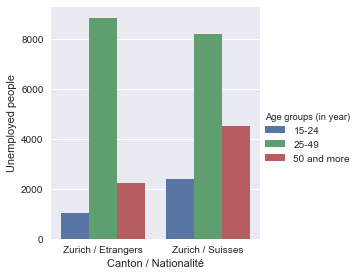

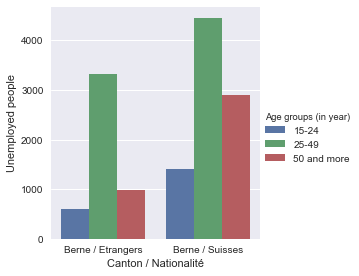

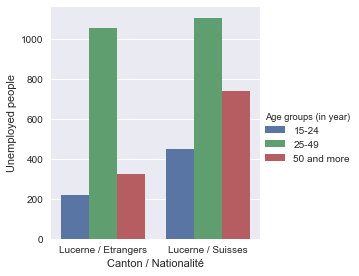

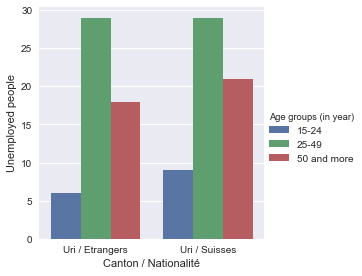

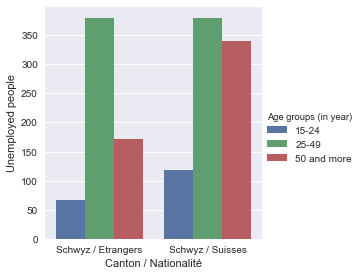

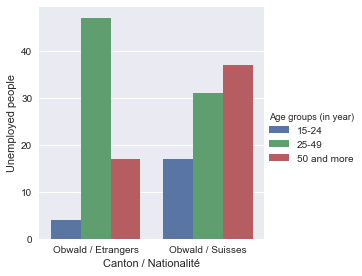

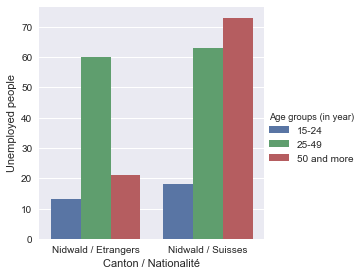

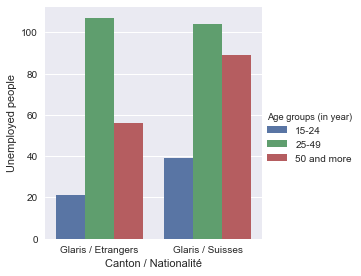

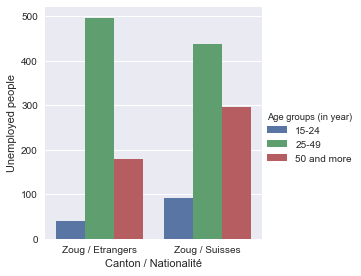

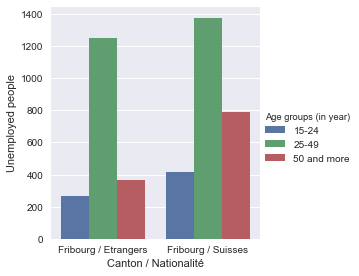

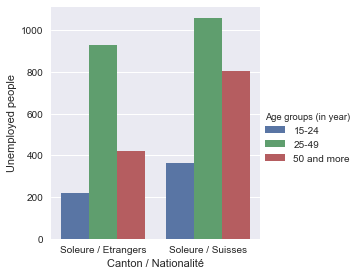

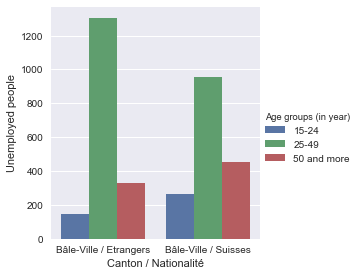

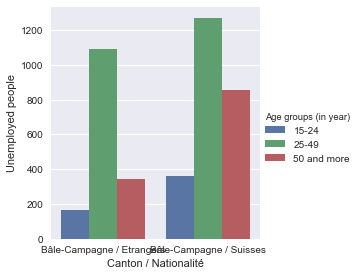

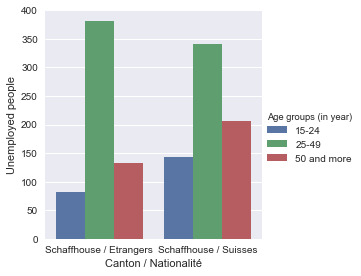

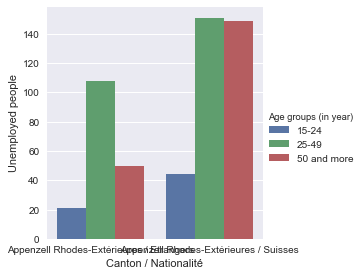

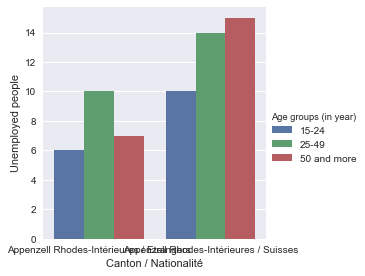

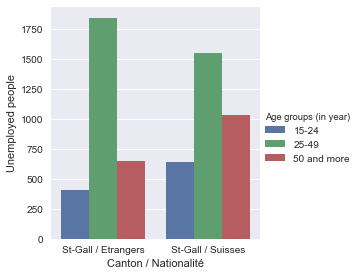

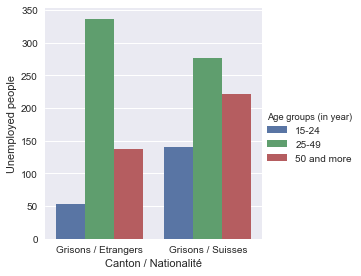

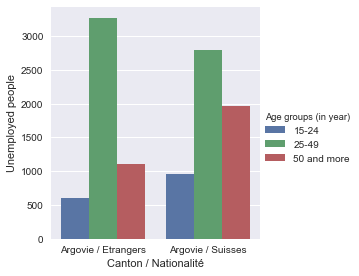

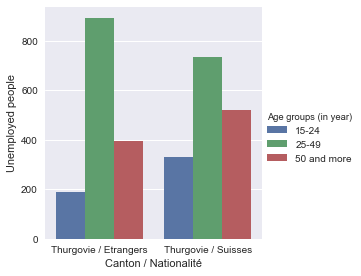

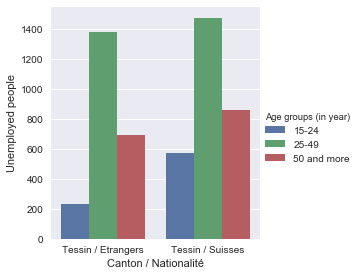

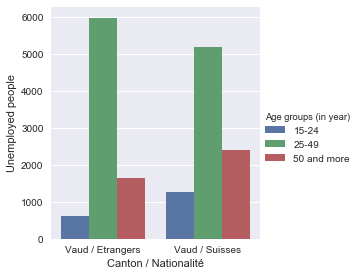

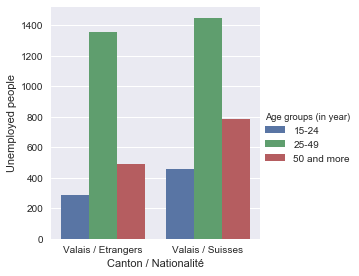

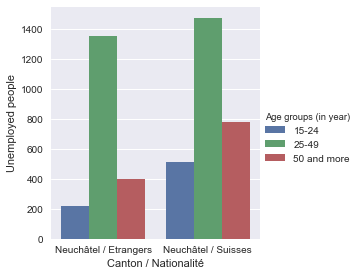

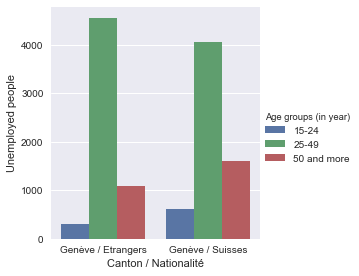

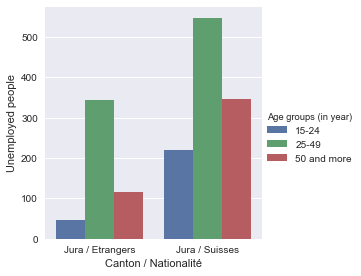

In [24]:
swiss_foreign_age_abs = pd.read_excel('chomage_suisse_etrangers_age.xlsx', skiprows=[1, 236],parse_cols=[0,1,2,5])

swiss_foreign_age_abs = swiss_foreign_age_abs.rename(columns={'Septembre 2017':'Unemployed people', 'Classes d\'âge 15-24, 25-49, 50 ans et plus':'Age groups (in year)'})
a = swiss_foreign_age_abs.loc[swiss_foreign_age_abs.iloc[:,1] != 'Total'].loc[swiss_foreign_age_abs.iloc[:,2] != 'Total']#.iloc[:,[0,1, 2,3]]

a['Age groups (in year)'] = a['Age groups (in year)'].astype('category')
a['Age groups (in year)'].cat.categories = ['15-24', '25-49', '50 and more']
a['Canton / Nationalité'] = a.Canton + ' / ' + a.Nationalité

#Version 2
for canton in a.Canton.unique():
    sns.factorplot(hue='Age groups (in year)', x='Canton / Nationalité', y='Unemployed people', aspect=1, kind='bar', data=a.loc[a.iloc[:, 0] == canton])
    plt.show()

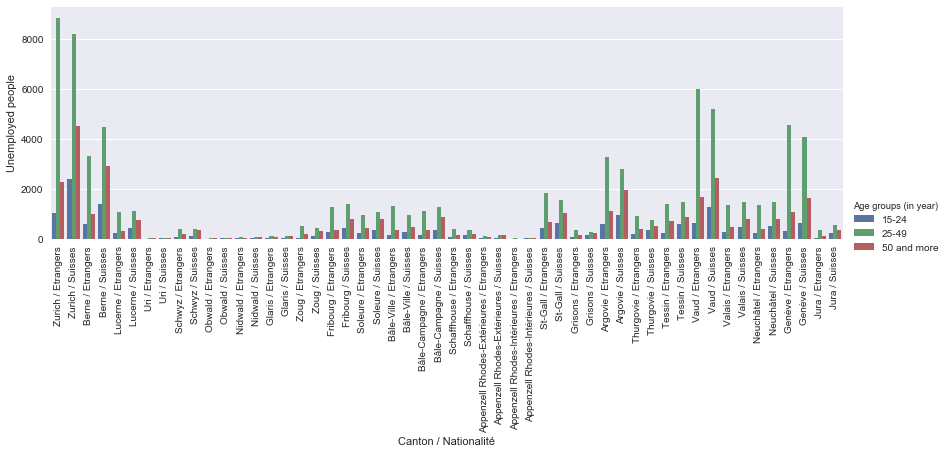

In [25]:
#Version 1
g = sns.factorplot(hue='Age groups (in year)', x='Canton / Nationalité', y='Unemployed people', aspect=3, kind='bar', data=a)
g.set_xticklabels(rotation=90)
plt.show()

## Question 4
-- --
*BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

-- --
When looking at the map given in Wikipedia, we understand that the Röstigraben 'Suisse romande' part contains Genève, Vaud, some part of Valais, some part of Fribourg, Neuchâtel, Jura and a small part of Bern.

As we want rates for both parts, we accumulate the active population of both parts, the unemployed people numbers of both parts, and we do unemployed/active.

To obtain the numbers, we use the dataset of the first part of question 3. However, this time we use one more column containing the numbers of unemployed people (column 4). To get the active population per canton, we do unemployed people/unemployment rate. As we had data per Nationality, we groupby canton and sum both 'Etrangers' and 'Suisses' rows per canton.

In [26]:
rostigraben = pd.read_excel('chomage_suisse_etrangers.xlsx', skiprows=[1,54],parse_cols=[0, 1,4,5])
rostigraben = rostigraben.rename(columns={'Septembre 2017':'Unemployed'})
rostigraben['Active'] = np.round(rostigraben['Unemployed']*100 / rostigraben['Total'])
total = rostigraben.groupby('Canton')['Active'].sum()

leftPart = ['Genève', 'Vaud', 'Valais', 'Fribourg', 'Neuchâtel', 'Jura']
rightPart = np.array(list(set(total.index) - set(leftPart)))

leftPartTotal = total[leftPart].sum()
rightPartTotal = total[rightPart].sum()

unemployed = rostigraben.groupby('Canton')['Unemployed'].sum()

leftPartUnemployed = unemployed[leftPart].sum()
rightPartUnemployed = unemployed[rightPart].sum()


print('Unemployment rate in Suisse romande : {0:.2f}%'.format(leftPartUnemployed*100/leftPartTotal))
print('Unemployment rate in Suisse alémanique : {0:.2f}%'.format(rightPartUnemployed*100/rightPartTotal))

Unemployment rate in Suisse romande : 4.11%
Unemployment rate in Suisse alémanique : 2.58%
